In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

In [14]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [15]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [16]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [17]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500

In [19]:
nepochs=200

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 477.95it/s]

Training loss [0.91289] Validation loss [0.64197713]
----New best validation loss---- [0.64197713]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.48it/s]

Training loss [0.5946624] Validation loss [0.5576443]
----New best validation loss---- [0.5576443]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.25it/s]

Training loss [0.53956896] Validation loss [0.5148862]
----New best validation loss---- [0.5148862]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.04it/s]

Training loss [0.509069] Validation loss [0.49222815]
----New best validation loss---- [0.49222815]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.38it/s]

Training loss [0.48839] Validation loss [0.48154882]
----New best validation loss---- [0.48154882]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 452.65it/s]

Training loss [0.47296596] Validation loss [0.467818]
----New best validation loss---- [0.467818]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.42it/s]

Training loss [0.46259117] Validation loss [0.45484436]
----New best validation loss---- [0.45484436]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.13it/s]

Training loss [0.4520265] Validation loss [0.45385006]
----New best validation loss---- [0.45385006]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.44it/s]

Training loss [0.44638997] Validation loss [0.44112587]
----New best validation loss---- [0.44112587]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.64it/s]

Training loss [0.4364481] Validation loss [0.42944288]
----New best validation loss---- [0.42944288]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.30it/s]

Training loss [0.43309438] Validation loss [0.4281889]
----New best validation loss---- [0.4281889]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.97it/s]

Training loss [0.42722332] Validation loss [0.4314068]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.09it/s]

Training loss [0.42280534] Validation loss [0.418761]
----New best validation loss---- [0.418761]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.26it/s]

Training loss [0.41881087] Validation loss [0.41361582]
----New best validation loss---- [0.41361582]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.08it/s]


Training loss [0.41730127] Validation loss [0.4177808]
Epoch 16


Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.08it/s]

Training loss [0.41248575] Validation loss [0.42729577]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.62it/s]

Training loss [0.40934828] Validation loss [0.41029304]
----New best validation loss---- [0.41029304]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 527.54it/s]

Training loss [0.4072121] Validation loss [0.4017006]
----New best validation loss---- [0.4017006]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.10it/s]

Training loss [0.40587023] Validation loss [0.40492418]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.47it/s]

Training loss [0.40217516] Validation loss [0.4013103]
----New best validation loss---- [0.4013103]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.62it/s]

Training loss [0.40006655] Validation loss [0.39549503]
----New best validation loss---- [0.39549503]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.28it/s]


Training loss [0.39788434] Validation loss [0.40009922]
Epoch 23


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.67it/s]

Training loss [0.3951671] Validation loss [0.3932529]
----New best validation loss---- [0.3932529]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.16it/s]

Training loss [0.3945777] Validation loss [0.39168236]
----New best validation loss---- [0.39168236]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.48it/s]

Training loss [0.3912136] Validation loss [0.39860207]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.90it/s]


Training loss [0.3909321] Validation loss [0.38969988]
----New best validation loss---- [0.38969988]
Epoch 27


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.78it/s]


Training loss [0.38794306] Validation loss [0.38487935]
----New best validation loss---- [0.38487935]
Epoch 28


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.41it/s]


Training loss [0.38706842] Validation loss [0.38961032]
Epoch 29


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.45it/s]


Training loss [0.38680995] Validation loss [0.38371837]
----New best validation loss---- [0.38371837]
Epoch 30


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.86it/s]


Training loss [0.3850982] Validation loss [0.38498357]
Epoch 31


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.68it/s]


Training loss [0.38447607] Validation loss [0.38254824]
----New best validation loss---- [0.38254824]
Epoch 32


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.64it/s]


Training loss [0.3813041] Validation loss [0.39465258]
Epoch 33


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.51it/s]


Training loss [0.38194767] Validation loss [0.3856084]
Epoch 34


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.72it/s]


Training loss [0.37962416] Validation loss [0.3788963]
----New best validation loss---- [0.3788963]
Epoch 35


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.70it/s]


Training loss [0.37849152] Validation loss [0.37739062]
----New best validation loss---- [0.37739062]
Epoch 36


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.69it/s]


Training loss [0.37793848] Validation loss [0.3769399]
----New best validation loss---- [0.3769399]
Epoch 37


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.18it/s]


Training loss [0.37591183] Validation loss [0.37729457]
Epoch 38


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.72it/s]


Training loss [0.37611857] Validation loss [0.38183463]
Epoch 39


Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.24it/s]

Training loss [0.37430337] Validation loss [0.37888762]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.37it/s]

Training loss [0.37306526] Validation loss [0.37195784]
----New best validation loss---- [0.37195784]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.98it/s]

Training loss [0.37166268] Validation loss [0.37242046]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:00<00:00, 374.14it/s]

Training loss [0.37058365] Validation loss [0.37341237]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.44it/s]

Training loss [0.3712488] Validation loss [0.37225142]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.95it/s]

Training loss [0.37028632] Validation loss [0.37756175]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.05it/s]


Training loss [0.3678631] Validation loss [0.37127817]
----New best validation loss---- [0.37127817]
Epoch 46


Batch number: 100%|██████████| 361/361 [00:00<00:00, 403.20it/s]

Training loss [0.36786547] Validation loss [0.37292194]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.31it/s]

Training loss [0.36675856] Validation loss [0.37084547]
----New best validation loss---- [0.37084547]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.38it/s]

Training loss [0.36610422] Validation loss [0.3697398]
----New best validation loss---- [0.3697398]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.28it/s]

Training loss [0.3654162] Validation loss [0.3632517]
----New best validation loss---- [0.3632517]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.92it/s]


Training loss [0.36459613] Validation loss [0.3646562]
Epoch 51


Batch number: 100%|██████████| 361/361 [00:00<00:00, 529.68it/s]

Training loss [0.36302653] Validation loss [0.36738995]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.09it/s]

Training loss [0.36260787] Validation loss [0.3692398]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 496.05it/s]

Training loss [0.3619286] Validation loss [0.3674664]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.79it/s]

Training loss [0.36103573] Validation loss [0.3715612]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.64it/s]

Training loss [0.36000553] Validation loss [0.36680397]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.47it/s]

Training loss [0.35974303] Validation loss [0.36791512]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.68it/s]

Training loss [0.35945448] Validation loss [0.36342043]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.37it/s]

Training loss [0.3576981] Validation loss [0.3650207]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.39it/s]

Training loss [0.35682285] Validation loss [0.36499324]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.62it/s]

Training loss [0.3580953] Validation loss [0.36089903]
----New best validation loss---- [0.36089903]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.92it/s]

Training loss [0.35599196] Validation loss [0.36395943]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.13it/s]

Training loss [0.35480574] Validation loss [0.3589836]
----New best validation loss---- [0.3589836]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.67it/s]

Training loss [0.35458237] Validation loss [0.36192104]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.30it/s]

Training loss [0.35378858] Validation loss [0.3606303]
Epoch 65



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.39it/s]

Training loss [0.3535067] Validation loss [0.36367822]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:01<00:00, 338.12it/s]

Training loss [0.35256562] Validation loss [0.3577793]
----New best validation loss---- [0.3577793]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.38it/s]

Training loss [0.35224816] Validation loss [0.35689723]
----New best validation loss---- [0.35689723]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.49it/s]

Training loss [0.35209176] Validation loss [0.3530348]
----New best validation loss---- [0.3530348]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 411.14it/s]

Training loss [0.35204005] Validation loss [0.36256173]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:00<00:00, 367.20it/s]

Training loss [0.3512964] Validation loss [0.35759664]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 381.15it/s]


Training loss [0.35071126] Validation loss [0.35821804]
Epoch 72


Batch number: 100%|██████████| 361/361 [00:00<00:00, 365.48it/s]

Training loss [0.35056987] Validation loss [0.35427752]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.84it/s]

Training loss [0.349786] Validation loss [0.35300767]
----New best validation loss---- [0.35300767]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 361.69it/s]

Training loss [0.34862092] Validation loss [0.3521586]
----New best validation loss---- [0.3521586]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.82it/s]

Training loss [0.3482964] Validation loss [0.35702455]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:01<00:00, 360.31it/s]

Training loss [0.3487048] Validation loss [0.35296735]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 390.73it/s]

Training loss [0.34766713] Validation loss [0.34781837]
----New best validation loss---- [0.34781837]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.35it/s]


Training loss [0.34734526] Validation loss [0.35272464]
Epoch 79


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.17it/s]


Training loss [0.34695596] Validation loss [0.3546398]
Epoch 80


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.69it/s]


Training loss [0.34688658] Validation loss [0.34789464]
Epoch 81


Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.57it/s]

Training loss [0.3464118] Validation loss [0.35338637]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.37it/s]


Training loss [0.3456147] Validation loss [0.3476168]
----New best validation loss---- [0.3476168]
Epoch 83


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.50it/s]


Training loss [0.3454983] Validation loss [0.35413155]
Epoch 84


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.67it/s]


Training loss [0.34493497] Validation loss [0.35243034]
Epoch 85


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.50it/s]


Training loss [0.34464788] Validation loss [0.34757873]
----New best validation loss---- [0.34757873]
Epoch 86


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.91it/s]


Training loss [0.34413755] Validation loss [0.346728]
----New best validation loss---- [0.346728]
Epoch 87


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.24it/s]


Training loss [0.344423] Validation loss [0.35056984]
Epoch 88


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.64it/s]

Training loss [0.34340948] Validation loss [0.34751624]
Epoch 89



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.42it/s]

Training loss [0.3441186] Validation loss [0.3480079]


Epoch 90


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.52it/s]


Training loss [0.34285176] Validation loss [0.3501151]
Epoch 91


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.30it/s]


Training loss [0.34319755] Validation loss [0.35025468]
Epoch 92


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.61it/s]


Training loss [0.34178263] Validation loss [0.34935737]
Epoch 93


Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.90it/s]


Training loss [0.34221992] Validation loss [0.34794894]
Epoch 94


Batch number: 100%|██████████| 361/361 [00:00<00:00, 524.37it/s]

Training loss [0.34202695] Validation loss [0.34811914]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.70it/s]


Training loss [0.34111762] Validation loss [0.34820673]
Epoch 96


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.05it/s]

Training loss [0.34066433] Validation loss [0.347319]
Epoch 97



Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.35it/s]


Training loss [0.34100622] Validation loss [0.34832254]
Epoch 98


Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.08it/s]

Training loss [0.34063786] Validation loss [0.34376764]


----New best validation loss---- [0.34376764]
Epoch 99


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.97it/s]


Training loss [0.34053388] Validation loss [0.34853226]
Epoch 100


Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.52it/s]

Training loss [0.34018967] Validation loss [0.34479782]
Epoch 101



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.22it/s]


Training loss [0.33973232] Validation loss [0.34405524]
Epoch 102


Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.54it/s]

Training loss [0.33881697] Validation loss [0.3462494]
Epoch 103



Batch number: 100%|██████████| 361/361 [00:00<00:00, 522.04it/s]

Training loss [0.33900416] Validation loss [0.34687507]
Epoch 104



Batch number: 100%|██████████| 361/361 [00:00<00:00, 531.82it/s]

Training loss [0.33894852] Validation loss [0.34753564]
Epoch 105



Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.24it/s]

Training loss [0.33870968] Validation loss [0.34189525]


----New best validation loss---- [0.34189525]
Epoch 106


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.06it/s]

Training loss [0.33773112] Validation loss [0.34429768]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.46it/s]

Training loss [0.33778378] Validation loss [0.34110722]
----New best validation loss---- [0.34110722]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.13it/s]

Training loss [0.33778873] Validation loss [0.34515375]
Epoch 109



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.35it/s]

Training loss [0.33752176] Validation loss [0.3422184]
Epoch 110



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.50it/s]

Training loss [0.33754656] Validation loss [0.34158134]
Epoch 111



Batch number: 100%|██████████| 361/361 [00:00<00:00, 506.13it/s]

Training loss [0.33717337] Validation loss [0.34715855]
Epoch 112



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.98it/s]

Training loss [0.3370154] Validation loss [0.34122166]
Epoch 113



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.62it/s]

Training loss [0.33641616] Validation loss [0.3453198]
Epoch 114



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.58it/s]

Training loss [0.33612236] Validation loss [0.34016123]
----New best validation loss---- [0.34016123]
Epoch 115



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.67it/s]

Training loss [0.33541363] Validation loss [0.34315276]
Epoch 116



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.82it/s]

Training loss [0.33601692] Validation loss [0.3402225]
Epoch 117



Batch number: 100%|██████████| 361/361 [00:00<00:00, 506.36it/s]

Training loss [0.33586118] Validation loss [0.33832037]
----New best validation loss---- [0.33832037]
Epoch 118



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.59it/s]

Training loss [0.33499658] Validation loss [0.34044164]
Epoch 119



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.70it/s]

Training loss [0.33417717] Validation loss [0.34066212]
Epoch 120



Batch number: 100%|██████████| 361/361 [00:00<00:00, 506.78it/s]

Training loss [0.33491164] Validation loss [0.339651]
Epoch 121



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.84it/s]

Training loss [0.33547226] Validation loss [0.34147236]
Epoch 122



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.87it/s]

Training loss [0.3341897] Validation loss [0.34596345]
Epoch 123



Batch number: 100%|██████████| 361/361 [00:00<00:00, 506.82it/s]

Training loss [0.3335935] Validation loss [0.33798647]
----New best validation loss---- [0.33798647]
Epoch 124



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.66it/s]


Training loss [0.3336741] Validation loss [0.3419769]
Epoch 125


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.84it/s]


Training loss [0.33367044] Validation loss [0.33853674]
Epoch 126


Batch number: 100%|██████████| 361/361 [00:00<00:00, 538.87it/s]

Training loss [0.33300206] Validation loss [0.33856836]
Epoch 127



Batch number: 100%|██████████| 361/361 [00:00<00:00, 528.82it/s]

Training loss [0.3331606] Validation loss [0.338226]
Epoch 128



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.34it/s]


Training loss [0.33350432] Validation loss [0.33803833]
Epoch 129


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.62it/s]


Training loss [0.33212304] Validation loss [0.34009296]
Epoch 130


Batch number: 100%|██████████| 361/361 [00:00<00:00, 395.27it/s]

Training loss [0.33287773] Validation loss [0.33817598]
Epoch 131



Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.54it/s]

Training loss [0.33188626] Validation loss [0.33941785]
Epoch 132



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.25it/s]

Training loss [0.33284777] Validation loss [0.33946967]
Epoch 133



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.00it/s]

Training loss [0.33244798] Validation loss [0.33703488]
----New best validation loss---- [0.33703488]
Epoch 134



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.16it/s]

Training loss [0.33202747] Validation loss [0.33970156]
Epoch 135



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.36it/s]

Training loss [0.3317922] Validation loss [0.338224]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.27it/s]

Training loss [0.33201134] Validation loss [0.3392343]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.44it/s]


Training loss [0.33202818] Validation loss [0.33932945]
Epoch 138


Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.97it/s]

Training loss [0.33109394] Validation loss [0.3415218]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.75it/s]

Training loss [0.33213982] Validation loss [0.3368669]
----New best validation loss---- [0.3368669]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 380.34it/s]

Training loss [0.33080274] Validation loss [0.33794013]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 386.30it/s]

Training loss [0.33051628] Validation loss [0.33884737]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.06it/s]


Training loss [0.33045718] Validation loss [0.33670154]
----New best validation loss---- [0.33670154]
Epoch 143


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.11it/s]


Training loss [0.33018056] Validation loss [0.33765662]
Epoch 144


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.25it/s]


Training loss [0.32992348] Validation loss [0.3409316]
Epoch 145


Batch number: 100%|██████████| 361/361 [00:00<00:00, 520.18it/s]


Training loss [0.3300879] Validation loss [0.3372424]
Epoch 146


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.04it/s]


Training loss [0.3303633] Validation loss [0.3339762]
----New best validation loss---- [0.3339762]
Epoch 147


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.49it/s]


Training loss [0.32961795] Validation loss [0.33801213]
Epoch 148


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.09it/s]

Training loss [0.32970122] Validation loss [0.33357444]
----New best validation loss---- [0.33357444]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.13it/s]

Training loss [0.3289515] Validation loss [0.33987346]
Epoch 150



Batch number: 100%|██████████| 361/361 [00:00<00:00, 466.82it/s]

Training loss [0.32923883] Validation loss [0.33607265]
Epoch 151



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.63it/s]

Training loss [0.3300414] Validation loss [0.33584693]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.04it/s]

Training loss [0.32820013] Validation loss [0.33407906]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.47it/s]

Training loss [0.32937244] Validation loss [0.33596694]
Epoch 154



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.88it/s]


Training loss [0.32825312] Validation loss [0.33491796]
Epoch 155


Batch number: 100%|██████████| 361/361 [00:00<00:00, 463.05it/s]

Training loss [0.328075] Validation loss [0.33866316]
Epoch 156



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.98it/s]


Training loss [0.32830098] Validation loss [0.3329467]
----New best validation loss---- [0.3329467]
Epoch 157


Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.45it/s]

Training loss [0.32836178] Validation loss [0.33681527]


Epoch 158


Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.63it/s]

Training loss [0.32899702] Validation loss [0.33460414]
Epoch 159



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.46it/s]

Training loss [0.32789522] Validation loss [0.33662644]
Epoch 160



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.28it/s]


Training loss [0.32734373] Validation loss [0.33241296]
----New best validation loss---- [0.33241296]
Epoch 161


Batch number: 100%|██████████| 361/361 [00:00<00:00, 378.12it/s]


Training loss [0.3275505] Validation loss [0.333185]
Epoch 162


Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.94it/s]

Training loss [0.32688707] Validation loss [0.3363012]
Epoch 163



Batch number: 100%|██████████| 361/361 [00:00<00:00, 485.71it/s]

Training loss [0.32710153] Validation loss [0.3383662]
Epoch 164



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.87it/s]

Training loss [0.3270141] Validation loss [0.3353871]
Epoch 165



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.27it/s]

Training loss [0.32716343] Validation loss [0.3357858]
Epoch 166



Batch number: 100%|██████████| 361/361 [00:00<00:00, 492.56it/s]

Training loss [0.32738474] Validation loss [0.3340783]
Epoch 167



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.19it/s]

Training loss [0.32742956] Validation loss [0.33333412]
Epoch 168



Batch number: 100%|██████████| 361/361 [00:00<00:00, 493.50it/s]

Training loss [0.32631564] Validation loss [0.33469415]
Epoch 169



Batch number: 100%|██████████| 361/361 [00:00<00:00, 494.58it/s]

Training loss [0.32652918] Validation loss [0.33375302]
Epoch 170



Batch number: 100%|██████████| 361/361 [00:00<00:00, 381.51it/s]

Training loss [0.32687667] Validation loss [0.3344279]
Epoch 171



Batch number: 100%|██████████| 361/361 [00:00<00:00, 487.38it/s]

Training loss [0.32638952] Validation loss [0.33506158]
Epoch 172



Batch number: 100%|██████████| 361/361 [00:00<00:00, 390.18it/s]

Training loss [0.32641768] Validation loss [0.33307728]
Epoch 173



Batch number: 100%|██████████| 361/361 [00:01<00:00, 357.54it/s]

Training loss [0.32579574] Validation loss [0.33295545]
Epoch 174



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.99it/s]

Training loss [0.32595623] Validation loss [0.33520433]
Epoch 175



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.36it/s]

Training loss [0.32629144] Validation loss [0.33227643]
----New best validation loss---- [0.33227643]
Epoch 176



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.88it/s]

Training loss [0.3250092] Validation loss [0.33434504]
Epoch 177



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.42it/s]

Training loss [0.32525808] Validation loss [0.3357122]
Epoch 178



Batch number: 100%|██████████| 361/361 [00:00<00:00, 362.91it/s]

Training loss [0.3256839] Validation loss [0.33407158]
Epoch 179



Batch number: 100%|██████████| 361/361 [00:00<00:00, 374.98it/s]

Training loss [0.32573587] Validation loss [0.33192188]
----New best validation loss---- [0.33192188]
Epoch 180



Batch number: 100%|██████████| 361/361 [00:00<00:00, 385.70it/s]


Training loss [0.32539338] Validation loss [0.33319733]
Epoch 181


Batch number: 100%|██████████| 361/361 [00:00<00:00, 362.93it/s]

Training loss [0.32461122] Validation loss [0.33166435]
----New best validation loss---- [0.33166435]
Epoch 182



Batch number: 100%|██████████| 361/361 [00:01<00:00, 357.73it/s]

Training loss [0.32482743] Validation loss [0.33409333]
Epoch 183



Batch number: 100%|██████████| 361/361 [00:00<00:00, 398.10it/s]

Training loss [0.32525057] Validation loss [0.3346078]
Epoch 184



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.10it/s]

Training loss [0.32456028] Validation loss [0.3377897]
Epoch 185



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.60it/s]

Training loss [0.32442483] Validation loss [0.33311784]
Epoch 186



Batch number: 100%|██████████| 361/361 [00:00<00:00, 376.14it/s]

Training loss [0.32367495] Validation loss [0.33181423]
Epoch 187



Batch number: 100%|██████████| 361/361 [00:00<00:00, 495.07it/s]

Training loss [0.32461193] Validation loss [0.33147863]
----New best validation loss---- [0.33147863]
Epoch 188



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.25it/s]

Training loss [0.32406136] Validation loss [0.33639452]
Epoch 189



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.67it/s]

Training loss [0.32395807] Validation loss [0.334681]
Epoch 190



Batch number: 100%|██████████| 361/361 [00:00<00:00, 361.92it/s]

Training loss [0.3236522] Validation loss [0.32998785]
----New best validation loss---- [0.32998785]
Epoch 191



Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.91it/s]


Training loss [0.32330504] Validation loss [0.3311713]
Epoch 192


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.80it/s]


Training loss [0.3242001] Validation loss [0.3342661]
Epoch 193


Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.36it/s]

Training loss [0.32373998] Validation loss [0.33103123]
Epoch 194



Batch number: 100%|██████████| 361/361 [00:01<00:00, 358.66it/s]

Training loss [0.3234064] Validation loss [0.33151722]
Epoch 195



Batch number: 100%|██████████| 361/361 [00:00<00:00, 376.39it/s]

Training loss [0.32344973] Validation loss [0.33005565]
Epoch 196



Batch number: 100%|██████████| 361/361 [00:00<00:00, 443.06it/s]

Training loss [0.32287815] Validation loss [0.33249503]
Epoch 197



Batch number: 100%|██████████| 361/361 [00:00<00:00, 519.91it/s]

Training loss [0.32249406] Validation loss [0.33178157]
Epoch 198



Batch number: 100%|██████████| 361/361 [00:00<00:00, 558.14it/s]

Training loss [0.3236708] Validation loss [0.33143586]
Epoch 199



Batch number: 100%|██████████| 361/361 [00:00<00:00, 558.03it/s]

Training loss [0.3226458] Validation loss [0.3311018]
Epoch 200



Batch number: 100%|██████████| 361/361 [00:00<00:00, 371.26it/s]

Training loss [0.32289982] Validation loss [0.32882047]


----New best validation loss---- [0.32882047]
Best model out of total max epochs found at epoch 200


In [20]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
outrate=QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [21]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Outrate: "+str(outrate))
print("R2 score: "+str(r2))

MSE: 0.0035928524123210685
PSNR: 29.142928258629922
Outrate: 0.19076666666666667
R2 score: 0.9523515044202665


In [41]:
model_metrics=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])
model_metrics

,MSE,PSNR,R2_score,Outrate
0,0.003593,29.142928,0.952352,0.190767


In [42]:
model_metrics_2=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])

In [43]:
model_cat=pd.concat([model_metrics,model_metrics_2])
model_cat=model_cat.reset_index(drop=True)
model_cat

,MSE,PSNR,R2_score,Outrate
0,0.003593,29.142928,0.952352,0.190767
1,0.003593,29.142928,0.952352,0.190767


## Visualise

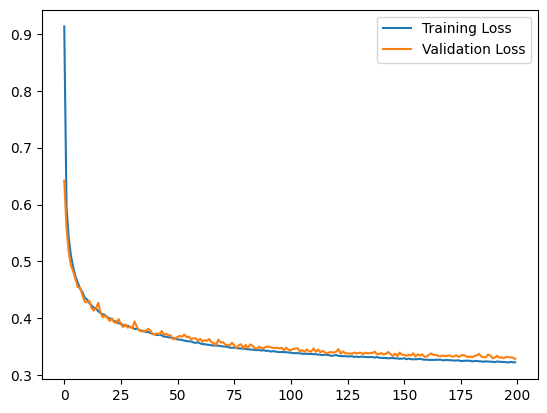

In [22]:
plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.legend(['Training Loss','Validation Loss'])

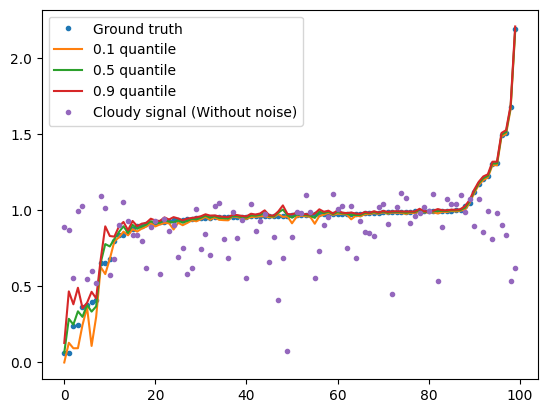

In [ ]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


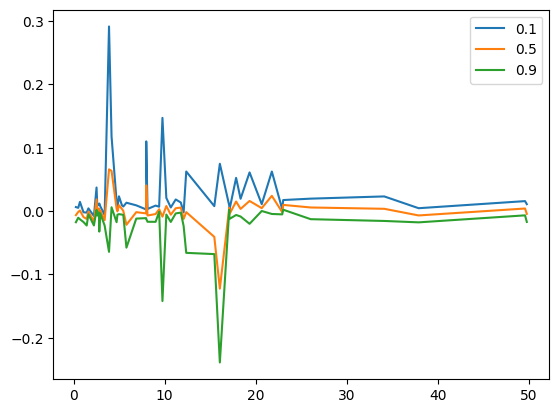

In [ ]:
channel=5
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

In [ ]:
hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)

## Test multiple runs

In [ ]:
num_epochs=[10,20]

sequential_models=[ 
lambda: nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels))
),
lambda: nn.Sequential(
    nn.Linear(len(X_labels),128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128, len(quantiles)*len(y_labels))
)]

In [ ]:
sequential_models[0]

<function __main__.<lambda>()>

In [ ]:
for nepochs in num_epochs:
    for i,sequantial in enumerate(sequential_models):
        
        model=QuantileNetwork(quantiles=quantiles)
        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequantial())
        
        hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs_'+'network_index_'+str(i),
                                    model=model,X_test=X_test,y_test=y_test)
        
                

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 378.62it/s]


Training loss [0.83696735] Validation loss [0.63547623]
----New best validation loss---- [0.63547623]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 379.59it/s]


Training loss [0.5936159] Validation loss [0.5662661]
----New best validation loss---- [0.5662661]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 367.38it/s]

Training loss [0.54953486] Validation loss [0.53734994]
----New best validation loss---- [0.53734994]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.23it/s]


Training loss [0.5261939] Validation loss [0.51872796]
----New best validation loss---- [0.51872796]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.82it/s]


Training loss [0.5097564] Validation loss [0.50228703]
----New best validation loss---- [0.50228703]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.73it/s]


Training loss [0.49633154] Validation loss [0.49053398]
----New best validation loss---- [0.49053398]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.14it/s]


Training loss [0.48624393] Validation loss [0.48696437]
----New best validation loss---- [0.48696437]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.10it/s]


Training loss [0.47754085] Validation loss [0.48830155]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 345.14it/s]


Training loss [0.47239843] Validation loss [0.4767115]
----New best validation loss---- [0.4767115]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.93it/s]


Training loss [0.46582168] Validation loss [0.47120282]
----New best validation loss---- [0.47120282]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.00it/s]


Training loss [0.74710727] Validation loss [0.59853846]
----New best validation loss---- [0.59853846]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.74it/s]


Training loss [0.5416226] Validation loss [0.51338124]
----New best validation loss---- [0.51338124]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.91it/s]


Training loss [0.5015558] Validation loss [0.49200144]
----New best validation loss---- [0.49200144]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.77it/s]


Training loss [0.47958708] Validation loss [0.46688986]
----New best validation loss---- [0.46688986]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.18it/s]


Training loss [0.46413198] Validation loss [0.46099007]
----New best validation loss---- [0.46099007]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.95it/s]


Training loss [0.4538667] Validation loss [0.44907513]
----New best validation loss---- [0.44907513]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.22it/s]


Training loss [0.44544902] Validation loss [0.43793103]
----New best validation loss---- [0.43793103]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.86it/s]


Training loss [0.43889317] Validation loss [0.43681064]
----New best validation loss---- [0.43681064]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.69it/s]


Training loss [0.43285266] Validation loss [0.43163306]
----New best validation loss---- [0.43163306]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.02it/s]


Training loss [0.42831337] Validation loss [0.4289991]
----New best validation loss---- [0.4289991]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 338.28it/s]


Training loss [0.8289272] Validation loss [0.6278596]
----New best validation loss---- [0.6278596]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.51it/s]


Training loss [0.59013146] Validation loss [0.5670168]
----New best validation loss---- [0.5670168]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.52it/s]

Training loss [0.54374343] Validation loss [0.52804935]
----New best validation loss---- [0.52804935]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.86it/s]


Training loss [0.51911163] Validation loss [0.5064952]
----New best validation loss---- [0.5064952]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.59it/s]

Training loss [0.50237507] Validation loss [0.4985021]
----New best validation loss---- [0.4985021]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 325.63it/s]


Training loss [0.4897616] Validation loss [0.48198858]
----New best validation loss---- [0.48198858]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.76it/s]


Training loss [0.47965378] Validation loss [0.4759047]
----New best validation loss---- [0.4759047]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.16it/s]


Training loss [0.4725613] Validation loss [0.4704416]
----New best validation loss---- [0.4704416]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.80it/s]


Training loss [0.4669337] Validation loss [0.4686748]
----New best validation loss---- [0.4686748]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.81it/s]


Training loss [0.46178782] Validation loss [0.46135437]
----New best validation loss---- [0.46135437]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]

Training loss [0.45694506] Validation loss [0.46262273]
Epoch 12



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 342.91it/s]


Training loss [0.45339295] Validation loss [0.4603163]
----New best validation loss---- [0.4603163]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.14it/s]

Training loss [0.45014533] Validation loss [0.45136273]
----New best validation loss---- [0.45136273]
Epoch 14



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.00it/s]


Training loss [0.44666174] Validation loss [0.44615167]
----New best validation loss---- [0.44615167]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.28it/s]


Training loss [0.44378883] Validation loss [0.45222077]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.28it/s]


Training loss [0.4417707] Validation loss [0.4412019]
----New best validation loss---- [0.4412019]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 344.93it/s]


Training loss [0.43858215] Validation loss [0.44448686]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]


Training loss [0.43712544] Validation loss [0.43949503]
----New best validation loss---- [0.43949503]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.32it/s]

Training loss [0.43471697] Validation loss [0.43649763]
----New best validation loss---- [0.43649763]
Epoch 20



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.94it/s]


Training loss [0.43274269] Validation loss [0.43574896]
----New best validation loss---- [0.43574896]
Best model out of total max epochs found at epoch 20
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.81it/s]


Training loss [0.75236434] Validation loss [0.578092]
----New best validation loss---- [0.578092]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 253.53it/s]


Training loss [0.54224783] Validation loss [0.51310426]
----New best validation loss---- [0.51310426]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.91it/s]


Training loss [0.49883968] Validation loss [0.4763381]
----New best validation loss---- [0.4763381]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.40it/s]


Training loss [0.4747396] Validation loss [0.4631469]
----New best validation loss---- [0.4631469]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.32it/s]


Training loss [0.45809036] Validation loss [0.456204]
----New best validation loss---- [0.456204]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.29it/s]


Training loss [0.44690385] Validation loss [0.44528773]
----New best validation loss---- [0.44528773]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.96it/s]


Training loss [0.43831152] Validation loss [0.4353292]
----New best validation loss---- [0.4353292]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.17it/s]

Training loss [0.43105376] Validation loss [0.42888376]


----New best validation loss---- [0.42888376]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.79it/s]


Training loss [0.42516756] Validation loss [0.41713938]
----New best validation loss---- [0.41713938]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.25it/s]


Training loss [0.41991258] Validation loss [0.42020005]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 269.22it/s]


Training loss [0.41629064] Validation loss [0.41809872]
Epoch 12


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.61it/s]


Training loss [0.41278514] Validation loss [0.4086831]
----New best validation loss---- [0.4086831]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 274.40it/s]


Training loss [0.4090438] Validation loss [0.40915322]
Epoch 14


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.58it/s]


Training loss [0.4074085] Validation loss [0.40762222]
----New best validation loss---- [0.40762222]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.62it/s]


Training loss [0.40382543] Validation loss [0.41051802]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.59it/s]


Training loss [0.4019043] Validation loss [0.4081948]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.45it/s]


Training loss [0.3994392] Validation loss [0.4008681]
----New best validation loss---- [0.4008681]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 255.08it/s]


Training loss [0.39684406] Validation loss [0.40343854]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.26it/s]


Training loss [0.39476365] Validation loss [0.3988069]
----New best validation loss---- [0.3988069]
Epoch 20


Batch number:   1%|▏         | 27/1805 [00:00<00:06, 267.24it/s]

## Testloading a model

In [ ]:
model, X_test, y_test = hf.load_model_and_test_data(filepath='pytorch_models/10epochs_network_index_0')

## Multiple runs again, with saved metrics

In [54]:
sequence= lambda: nn.Sequential(
    nn.Linear(len(X_labels),256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

In [67]:
num_epochs=[10,20]
num_models=3 #Set number of ensambles
batch_size=500
nepochs=200

looped_metric="Loop_nepochs"
main_filepath='pytorch_models/'+looped_metric

model_metrics=pd.DataFrame(columns=['Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Outrate'])
for nepochs in num_epochs:

    
    models=[QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]
    for i,model in enumerate(models):        

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence())
        
        filepath='pytorch_models/'+looped_metric+'/'+str(nepochs)+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

        preds = model.predict(X_test.to_numpy())
        mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
        psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
        outrate=QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)
        r2=r2_score(y_test.to_numpy(),preds[:,:,1])

        tmp_metrics=pd.DataFrame(data=[[i,nepochs,mse,psnr,r2,outrate]],columns=['Ensemble_index',looped_metric,'MSE','PSNR','R2_score','Outrate'])
        model_metrics=pd.concat([model_metrics,tmp_metrics])


X_test.to_csv(main_filepath+'/xtest.csv',index=False)
y_test.to_csv(main_filepath+'/ytest.csv',index=False)


model_metrics=model_metrics.reset_index(drop=True)


Epoch 1


Batch number:   0%|          | 0/361 [00:00<?, ?it/s]

Batch number: 100%|██████████| 361/361 [00:00<00:00, 417.65it/s]

Training loss [0.89771706] Validation loss [0.6363984]
----New best validation loss---- [0.6363984]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 429.30it/s]

Training loss [0.5923645] Validation loss [0.56153774]
----New best validation loss---- [0.56153774]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 430.59it/s]

Training loss [0.5373982] Validation loss [0.51886415]
----New best validation loss---- [0.51886415]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:01<00:00, 305.70it/s]

Training loss [0.5072212] Validation loss [0.48867437]
----New best validation loss---- [0.48867437]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.93it/s]

Training loss [0.4868395] Validation loss [0.49101403]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.17it/s]

Training loss [0.47072634] Validation loss [0.463929]
----New best validation loss---- [0.463929]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.21it/s]

Training loss [0.4600995] Validation loss [0.4559929]
----New best validation loss---- [0.4559929]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.25it/s]

Training loss [0.45002246] Validation loss [0.4516565]
----New best validation loss---- [0.4516565]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.42it/s]

Training loss [0.44232374] Validation loss [0.43556562]
----New best validation loss---- [0.43556562]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.19it/s]

Training loss [0.43680114] Validation loss [0.43095502]


----New best validation loss---- [0.43095502]
Best model out of total max epochs found at epoch 10
Epoch 1


/tmp/ipykernel_108532/997721966.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics=pd.concat([model_metrics,tmp_metrics])
Batch number: 100%|██████████| 361/361 [00:01<00:00, 312.02it/s]

Training loss [0.9088559] Validation loss [0.6346169]
----New best validation loss---- [0.6346169]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:01<00:00, 297.83it/s]


Training loss [0.5909364] Validation loss [0.55789083]
----New best validation loss---- [0.55789083]
Epoch 3


Batch number: 100%|██████████| 361/361 [00:01<00:00, 316.67it/s]

Training loss [0.53747207] Validation loss [0.5175785]
----New best validation loss---- [0.5175785]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 438.24it/s]

Training loss [0.5057498] Validation loss [0.48364606]
----New best validation loss---- [0.48364606]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.40it/s]

Training loss [0.48505548] Validation loss [0.48055077]
----New best validation loss---- [0.48055077]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 439.55it/s]

Training loss [0.47120202] Validation loss [0.46210748]
----New best validation loss---- [0.46210748]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.50it/s]

Training loss [0.45953193] Validation loss [0.45573297]
----New best validation loss---- [0.45573297]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 441.68it/s]

Training loss [0.44913363] Validation loss [0.44148704]
----New best validation loss---- [0.44148704]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.15it/s]

Training loss [0.44232318] Validation loss [0.43500265]
----New best validation loss---- [0.43500265]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 440.81it/s]

Training loss [0.43746048] Validation loss [0.43344042]


----New best validation loss---- [0.43344042]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 381.68it/s]

Training loss [0.9099362] Validation loss [0.6383002]
----New best validation loss---- [0.6383002]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.88it/s]

Training loss [0.5951538] Validation loss [0.56284875]
----New best validation loss---- [0.56284875]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:01<00:00, 300.71it/s]

Training loss [0.5377801] Validation loss [0.5165576]
----New best validation loss---- [0.5165576]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.41it/s]

Training loss [0.5068577] Validation loss [0.4947171]
----New best validation loss---- [0.4947171]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:01<00:00, 298.42it/s]


Training loss [0.4867062] Validation loss [0.48477316]
----New best validation loss---- [0.48477316]
Epoch 6


Batch number: 100%|██████████| 361/361 [00:01<00:00, 297.05it/s]


Training loss [0.46979505] Validation loss [0.46938655]
----New best validation loss---- [0.46938655]
Epoch 7


Batch number: 100%|██████████| 361/361 [00:00<00:00, 442.40it/s]


Training loss [0.45791757] Validation loss [0.45701617]
----New best validation loss---- [0.45701617]
Epoch 8


Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.54it/s]

Training loss [0.4497444] Validation loss [0.45031506]
----New best validation loss---- [0.45031506]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 379.98it/s]

Training loss [0.44042996] Validation loss [0.45562905]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.71it/s]

Training loss [0.43482053] Validation loss [0.42666876]


----New best validation loss---- [0.42666876]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 364.92it/s]


Training loss [0.88050735] Validation loss [0.6225236]
----New best validation loss---- [0.6225236]
Epoch 2


Batch number: 100%|██████████| 361/361 [00:01<00:00, 308.92it/s]

Training loss [0.5871286] Validation loss [0.54865277]
----New best validation loss---- [0.54865277]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:01<00:00, 313.49it/s]

Training loss [0.53275555] Validation loss [0.5183506]
----New best validation loss---- [0.5183506]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:01<00:00, 305.08it/s]

Training loss [0.5009481] Validation loss [0.48875386]
----New best validation loss---- [0.48875386]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:01<00:00, 306.17it/s]

Training loss [0.48087788] Validation loss [0.47100955]
----New best validation loss---- [0.47100955]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:01<00:00, 333.12it/s]

Training loss [0.46581453] Validation loss [0.45915818]
----New best validation loss---- [0.45915818]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:01<00:00, 303.37it/s]

Training loss [0.45465377] Validation loss [0.45062593]
----New best validation loss---- [0.45062593]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:01<00:00, 315.03it/s]

Training loss [0.4465022] Validation loss [0.4410863]
----New best validation loss---- [0.4410863]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.52it/s]

Training loss [0.43933016] Validation loss [0.43359694]
----New best validation loss---- [0.43359694]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:01<00:00, 300.92it/s]

Training loss [0.43305743] Validation loss [0.42828828]
----New best validation loss---- [0.42828828]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:01<00:00, 302.84it/s]

Training loss [0.42673725] Validation loss [0.42367357]
----New best validation loss---- [0.42367357]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:01<00:00, 311.04it/s]

Training loss [0.4230492] Validation loss [0.4215704]
----New best validation loss---- [0.4215704]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.25it/s]

Training loss [0.4195939] Validation loss [0.43223757]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 445.33it/s]


Training loss [0.41555497] Validation loss [0.41145867]
----New best validation loss---- [0.41145867]
Epoch 15


Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.45it/s]

Training loss [0.41122073] Validation loss [0.41603705]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.45it/s]

Training loss [0.4098231] Validation loss [0.40563792]
----New best validation loss---- [0.40563792]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.07it/s]

Training loss [0.40500963] Validation loss [0.40688223]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.95it/s]

Training loss [0.4033493] Validation loss [0.3997226]
----New best validation loss---- [0.3997226]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 437.64it/s]

Training loss [0.40041932] Validation loss [0.40166822]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.03it/s]

Training loss [0.39852095] Validation loss [0.40375638]


Best model out of total max epochs found at epoch 18
Epoch 1


Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.63it/s]

Training loss [0.90774494] Validation loss [0.62664866]
----New best validation loss---- [0.62664866]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.18it/s]

Training loss [0.59260875] Validation loss [0.5675734]
----New best validation loss---- [0.5675734]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.55it/s]

Training loss [0.5370913] Validation loss [0.52321833]
----New best validation loss---- [0.52321833]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.43it/s]

Training loss [0.5065585] Validation loss [0.5150528]
----New best validation loss---- [0.5150528]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.35it/s]

Training loss [0.48614824] Validation loss [0.47994784]
----New best validation loss---- [0.47994784]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.47it/s]

Training loss [0.47221857] Validation loss [0.46376166]
----New best validation loss---- [0.46376166]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.57it/s]

Training loss [0.46030492] Validation loss [0.4507756]
----New best validation loss---- [0.4507756]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 427.04it/s]

Training loss [0.44866145] Validation loss [0.45092994]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.51it/s]

Training loss [0.44208992] Validation loss [0.43256086]
----New best validation loss---- [0.43256086]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.76it/s]

Training loss [0.4351117] Validation loss [0.42904797]
----New best validation loss---- [0.42904797]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 428.56it/s]

Training loss [0.43021268] Validation loss [0.4265214]
----New best validation loss---- [0.4265214]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 426.74it/s]

Training loss [0.42602164] Validation loss [0.42495367]
----New best validation loss---- [0.42495367]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 436.43it/s]

Training loss [0.42033547] Validation loss [0.42817485]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.73it/s]

Training loss [0.41686612] Validation loss [0.41648304]
----New best validation loss---- [0.41648304]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.91it/s]

Training loss [0.41442707] Validation loss [0.4087349]
----New best validation loss---- [0.4087349]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.34it/s]

Training loss [0.40927288] Validation loss [0.4036722]
----New best validation loss---- [0.4036722]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 434.87it/s]

Training loss [0.4065041] Validation loss [0.41099727]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.16it/s]

Training loss [0.40352774] Validation loss [0.40253848]
----New best validation loss---- [0.40253848]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.80it/s]

Training loss [0.4024431] Validation loss [0.40432698]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:00<00:00, 435.14it/s]

Training loss [0.39919445] Validation loss [0.39893082]


----New best validation loss---- [0.39893082]
Best model out of total max epochs found at epoch 20
Epoch 1


Batch number: 100%|██████████| 361/361 [00:01<00:00, 331.37it/s]

Training loss [0.9020288] Validation loss [0.6544109]
----New best validation loss---- [0.6544109]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.14it/s]

Training loss [0.58744156] Validation loss [0.5624015]
----New best validation loss---- [0.5624015]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:01<00:00, 323.10it/s]

Training loss [0.53686583] Validation loss [0.5164966]
----New best validation loss---- [0.5164966]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:01<00:00, 302.46it/s]

Training loss [0.5075257] Validation loss [0.49553314]
----New best validation loss---- [0.49553314]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:01<00:00, 299.30it/s]

Training loss [0.4888695] Validation loss [0.4766109]


----New best validation loss---- [0.4766109]
Epoch 6


Batch number: 100%|██████████| 361/361 [00:01<00:00, 308.07it/s]

Training loss [0.47427738] Validation loss [0.46238995]
----New best validation loss---- [0.46238995]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:01<00:00, 303.09it/s]

Training loss [0.46218765] Validation loss [0.4606296]
----New best validation loss---- [0.4606296]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:01<00:00, 303.66it/s]

Training loss [0.45366442] Validation loss [0.45246032]
----New best validation loss---- [0.45246032]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:01<00:00, 302.54it/s]

Training loss [0.44648635] Validation loss [0.44304085]
----New best validation loss---- [0.44304085]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 368.29it/s]

Training loss [0.4412338] Validation loss [0.43638983]
----New best validation loss---- [0.43638983]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.20it/s]

Training loss [0.43580958] Validation loss [0.42764026]
----New best validation loss---- [0.42764026]
Epoch 12



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.46it/s]

Training loss [0.43079552] Validation loss [0.44357494]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:00<00:00, 425.12it/s]

Training loss [0.42625162] Validation loss [0.4270922]
----New best validation loss---- [0.4270922]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:00<00:00, 424.13it/s]

Training loss [0.42165017] Validation loss [0.4175907]
----New best validation loss---- [0.4175907]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.36it/s]

Training loss [0.41820043] Validation loss [0.41485223]
----New best validation loss---- [0.41485223]
Epoch 16



Batch number: 100%|██████████| 361/361 [00:00<00:00, 422.53it/s]

Training loss [0.4155889] Validation loss [0.41718942]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:00<00:00, 423.08it/s]

Training loss [0.41288802] Validation loss [0.40373868]
----New best validation loss---- [0.40373868]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:00<00:00, 387.46it/s]


Training loss [0.40940222] Validation loss [0.40940347]
Epoch 19


Batch number: 100%|██████████| 361/361 [00:01<00:00, 307.05it/s]

Training loss [0.40668723] Validation loss [0.4055986]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:01<00:00, 303.79it/s]

Training loss [0.40318558] Validation loss [0.40434965]


Best model out of total max epochs found at epoch 17


In [63]:
model_metrics

,Ensemble_index,Loop_nepochs,MSE,PSNR,R2_score,Outrate
0,0,10,0.004719,27.958464,0.934631,0.199933
1,1,10,0.004782,27.901045,0.934321,0.214800
2,2,10,0.004904,27.791987,0.932956,0.161575
3,0,20,0.004328,28.334275,0.939318,0.199608
4,1,20,0.004457,28.207127,0.938528,0.186817
5,2,20,0.004335,28.327338,0.940393,0.199408
